   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.0 MB/s eta 0:00:00


100%|██████████| 170M/170M [00:03<00:00, 47.9MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 176MB/s]



=== Training Task 0 ===
[Task 0] Epoch 1 Loss: 49.88
[Task 0] Epoch 2 Loss: 24.81
[Task 0] Epoch 3 Loss: 17.36
[Task 0] Epoch 4 Loss: 13.20
[Task 0] Epoch 5 Loss: 11.93
[Task 0] Epoch 6 Loss: 9.76
[Task 0] Epoch 7 Loss: 7.13
[Task 0] Epoch 8 Loss: 5.73
[Task 0] Epoch 9 Loss: 5.97
[Task 0] Epoch 10 Loss: 5.97
[Eval] Task 0 Accuracy: 97.20%

=== Training Task 1 ===
[Task 1] Epoch 1 Loss: 63.26
[Task 1] Epoch 2 Loss: 34.41
[Task 1] Epoch 3 Loss: 24.23
[Task 1] Epoch 4 Loss: 16.55
[Task 1] Epoch 5 Loss: 13.53
[Task 1] Epoch 6 Loss: 8.23
[Task 1] Epoch 7 Loss: 7.39
[Task 1] Epoch 8 Loss: 9.31
[Task 1] Epoch 9 Loss: 5.49
[Task 1] Epoch 10 Loss: 4.84
[Eval] Task 0 Accuracy: 86.35%
[Eval] Task 1 Accuracy: 87.70%

=== Training Task 2 ===
[Task 2] Epoch 1 Loss: 56.31
[Task 2] Epoch 2 Loss: 21.56
[Task 2] Epoch 3 Loss: 11.59
[Task 2] Epoch 4 Loss: 7.93
[Task 2] Epoch 5 Loss: 7.74
[Task 2] Epoch 6 Loss: 4.64
[Task 2] Epoch 7 Loss: 4.63
[Task 2] Epoch 8 Loss: 4.19
[Task 2] Epoch 9 Loss: 2.73
[Task

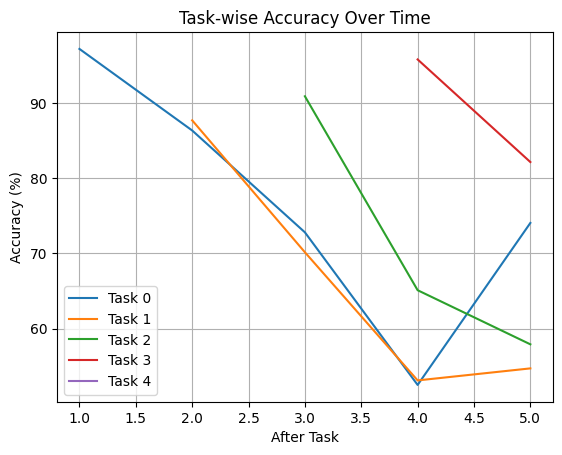

In [1]:
!pip install torchvision --quiet

import torch, random
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, TensorDataset
from torchvision import datasets, transforms, models
from collections import defaultdict
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------- Dataset: Split CIFAR-10 --------------------
def get_split_cifar10(num_tasks=5, batch_size=64):
    transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    full_train = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
    full_test = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

    classes_per_task = 10 // num_tasks
    train_loaders, test_loaders, task_classes = [], [], []

    for task_id in range(num_tasks):
        task_classes_list = list(range(task_id * classes_per_task, (task_id + 1) * classes_per_task))

        def filter_subset(dataset):
            x, y = [], []
            for i in range(len(dataset)):
                img, label = dataset[i]
                if label in task_classes_list:
                    x.append(img)
                    y.append(label - task_id * classes_per_task)
            return TensorDataset(torch.stack(x), torch.tensor(y))

        train_loader = DataLoader(filter_subset(full_train), batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(filter_subset(full_test), batch_size=1, shuffle=False)
        train_loaders.append(train_loader)
        test_loaders.append(test_loader)
        task_classes.append(classes_per_task)

    return train_loaders, test_loaders, task_classes

# -------------------- Balanced Replay Buffer --------------------
class BalancedReplayBuffer:
    def __init__(self, max_per_class=100):
        self.buffer = defaultdict(list)
        self.max_per_class = max_per_class

    def add(self, x, y):
        y = y.item()
        if len(self.buffer[y]) < self.max_per_class:
            self.buffer[y].append((x, y))
        else:
            self.buffer[y][random.randint(0, self.max_per_class - 1)] = (x, y)

    def sample(self, batch_size):
        all_data = sum(self.buffer.values(), [])
        if not all_data:
            return None, None
        batch = random.sample(all_data, min(batch_size, len(all_data)))
        x, y = zip(*batch)
        return torch.stack(x), torch.tensor(y)

# -------------------- Model --------------------
class ROWModel(nn.Module):
    def __init__(self, feature_dim, num_tasks, task_classes):
        super().__init__()
        resnet = models.resnet18(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-1])
        self.flatten = nn.Flatten()
        self.wp_heads = nn.ModuleList([nn.Linear(feature_dim, c) for c in task_classes])
        self.ood_heads = nn.ModuleList([nn.Linear(feature_dim, c + 1) for c in task_classes])

    def forward(self, x, task_id, head_type='wp'):
        features = self.flatten(self.feature_extractor(x))
        if head_type == 'wp':
            return self.wp_heads[task_id](features)
        else:
            return self.ood_heads[task_id](features)

# -------------------- Training Step --------------------
def train_task(model, task_id, train_loader, optimizer, buffer, epochs=10, temperature=1.5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            rx, ry = buffer.sample(len(x))
            if rx is not None:
                rx, ry = rx.to(device), ry.to(device)
                combined_x = torch.cat([x, rx])
                wp_y = torch.cat([y, ry])
                ood_y = torch.cat([
                    y,
                    torch.full((len(rx),), model.ood_heads[task_id].out_features - 1, dtype=torch.long, device=device)
                ])
            else:
                combined_x = x
                wp_y = y
                ood_y = y

            wp_out = model(combined_x, task_id, 'wp') / temperature
            ood_out = model(combined_x, task_id, 'ood') / temperature

            loss_wp = F.cross_entropy(wp_out, wp_y)
            loss_ood = F.cross_entropy(ood_out, ood_y)
            loss = loss_wp + 0.5 * loss_ood

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"[Task {task_id}] Epoch {epoch+1} Loss: {total_loss:.2f}")

# -------------------- Inference --------------------
def inference(model, x, num_tasks, temperature=1.5):
    model.eval()
    x = x.unsqueeze(0).to(device)
    with torch.no_grad():
        scores = []
        for tid in range(num_tasks):
            wp = F.softmax(model(x, tid, 'wp') / temperature, dim=1)
            ood = F.softmax(model(x, tid, 'ood') / temperature, dim=1)[:, :-1]
            combined = (wp * ood).sum(dim=1)
            scores.append(combined)
        best_task = torch.argmax(torch.tensor(scores)).item()
        pred = torch.argmax(F.softmax(model(x, best_task, 'wp'), dim=1)).item()
    return pred

# -------------------- Evaluation --------------------
def evaluate(model, test_loaders, num_tasks):
    acc = []
    for tid, loader in enumerate(test_loaders):
        correct = 0
        for x, y in loader:
            pred = inference(model, x.squeeze(0), num_tasks)
            correct += (pred == y.item())
        accuracy = correct / len(loader) * 100
        acc.append(accuracy)
        print(f"[Eval] Task {tid} Accuracy: {accuracy:.2f}%")
    return acc

# -------------------- Main Training Loop --------------------
def run():
    train_loaders, test_loaders, task_classes = get_split_cifar10()
    model = ROWModel(512, num_tasks=5, task_classes=task_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    buffer = BalancedReplayBuffer(max_per_class=100)
    all_acc = []

    for tid in range(5):
        print(f"\n=== Training Task {tid} ===")
        train_task(model, tid, train_loader=train_loaders[tid], optimizer=optimizer, buffer=buffer, epochs=10)

        for x, y in train_loaders[tid]:
            for xi, yi in zip(x, y):
                buffer.add(xi.cpu(), yi)

        acc = evaluate(model, test_loaders[:tid+1], tid+1)
        all_acc.append(acc)

    return all_acc

# -------------------- Run and Plot --------------------
accuracies = run()
for t in range(len(accuracies)):
    task_acc = [a[t] if t < len(a) else None for a in accuracies]
    plt.plot(range(1, len(accuracies)+1), task_acc, label=f'Task {t}')
plt.title("Task-wise Accuracy Over Time")
plt.xlabel("After Task")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.legend()
plt.show()